In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Infer using SSD300_VGG16

In [52]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import ssd300_vgg16

model = ssd300_vgg16(pretrained=False)
model.head.classification_head.num_classes = 9
model.load_state_dict(torch.load('/kaggle/input/weightsod/ssd_vgg16_coco.pth'))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat'
]

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.ToTensor()
    ])
    return transform(image).unsqueeze(0)

def predict_image(image_path, model, device):
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
    return outputs

def display_predictions(image_path, predictions, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    ax = plt.gca()

    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    labels -= 1
    for box, score, label in zip(boxes, scores, labels):
        if score >= threshold:  
            x_min, y_min, x_max, y_max = box
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'{COCO_INSTANCE_CATEGORY_NAMES[label]}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')
    
    plt.axis('off')
    plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread("/kaggle/input/coco-2017-dataset/coco2017/train2017/000000003035.jpg")
def show_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
show_image(im)

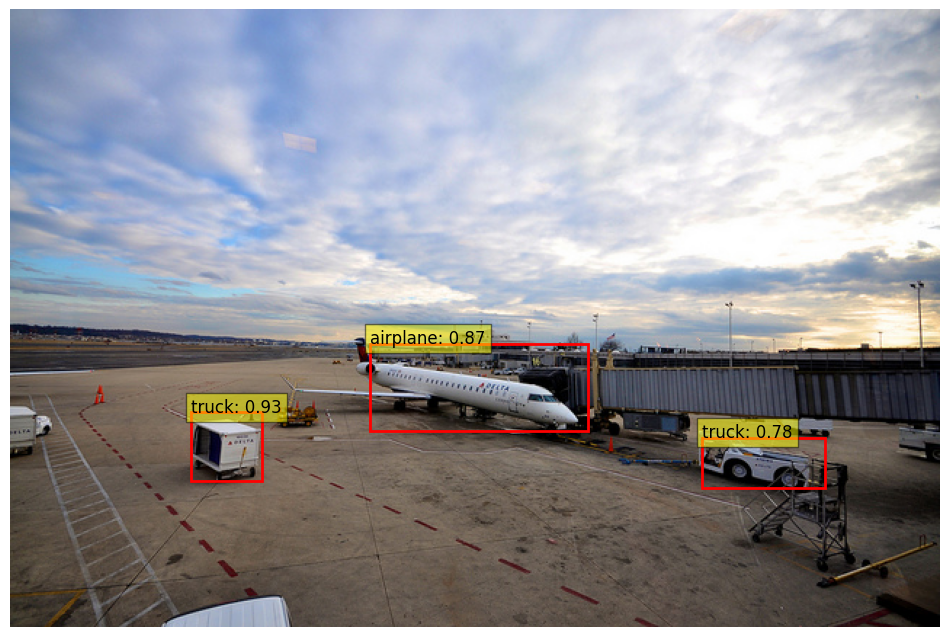

In [56]:
image_path = "/kaggle/input/coco-2017-dataset/coco2017/train2017/000000003035.jpg"
predictions = predict_image(image_path, model, device)
display_predictions(image_path, predictions, threshold=0.4)

# Infer using Retina_R50 through detectron2

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor, launch
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1g_mzakk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1g_mzakk
  Resolved https://github.com/facebookresearch/detectron2.git to commit e8806d607403cf0f2634d4c5ac464109fdc7d4af
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.

In [39]:
setup_logger()
data_path = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
train_ann_file = "/kaggle/input/semis-od-coco-10/instances_train2017_labeled.json"
val_ann_file = "/kaggle/input/semis-od-coco-10/instances_val2017.json"

register_coco_instances("coco_train", {}, train_ann_file, data_path)
register_coco_instances("coco_val", {}, val_ann_file, data_path)

class_names = ["bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat"]

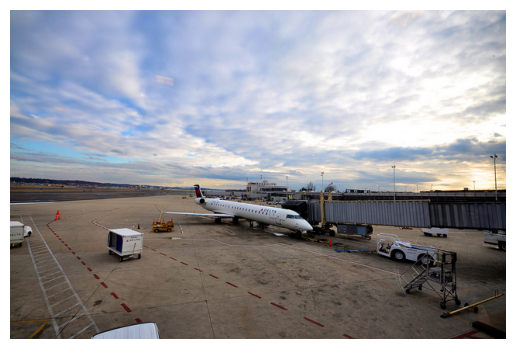

In [57]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode

im = cv2.imread("/kaggle/input/coco-2017-dataset/coco2017/train2017/000000003035.jpg")
def show_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
show_image(im)

In [72]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("coco_train",)
cfg.DATASETS.TEST = ("coco_val",)
cfg.MODEL.RETINANET.NUM_CLASSES = 8
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.15

cfg.MODEL.WEIGHTS = os.path.join('/kaggle/input/weightretinatest/retinafull1530.pth')
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3  


predictor = DefaultPredictor(cfg)

[06/17 21:04:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/weightretinatest/retinafull1530.pth ...


[06/17 21:09:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/weightretinatest/retinafull1530.pth ...


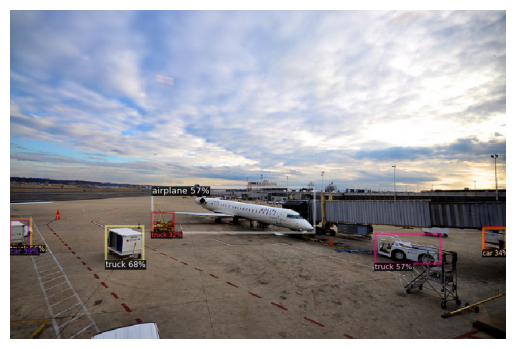

In [88]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes = class_names
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2) 

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
output_image = out.get_image()[:, :, ::-1]
cv2.imwrite('/path/to/save/annotated_image.jpg', output_image)  
show_image(output_image)

In [85]:
# outputs = predictor(im)
# pred_classes = outputs["instances"].pred_classes
# pred_class_names = [class_names[i] for i in pred_classes]
# print(pred_class_names)
# print(outputs["instances"].pred_boxes)

['truck', 'airplane', 'truck', 'truck', 'car', 'truck', 'car', 'truck']
Boxes(tensor([[1.2297e+02, 2.7942e+02, 1.7196e+02, 3.2437e+02],
        [1.8328e+02, 2.2908e+02, 3.9227e+02, 2.8728e+02],
        [4.7075e+02, 2.8876e+02, 5.5537e+02, 3.2792e+02],
        [0.0000e+00, 2.7053e+02, 2.6756e+01, 3.0469e+02],
        [3.0197e-01, 2.7164e+02, 2.3028e+01, 3.0803e+02],
        [6.1089e+02, 2.8116e+02, 6.3990e+02, 3.1019e+02],
        [6.1000e+02, 2.8246e+02, 6.3920e+02, 3.1123e+02],
        [1.8256e+02, 2.6132e+02, 2.1091e+02, 2.8766e+02]], device='cuda:0'))


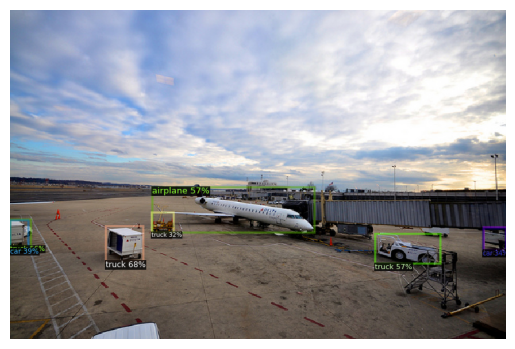

In [86]:
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# output_image = out.get_image()[:, :, ::-1]
# output_image_path = 'output_image.png'
# #cv2.imwrite(output_image_path, output_image)

# show_image(output_image)